In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import lightgbm as lgb
import pandas as pd
import seaborn as sns
import sklearn
import sqlalchemy
from dotenv import load_dotenv
from sklearn import metrics
from sklearn.model_selection import KFold, check_cv
from sklearn.preprocessing import FunctionTransformer

from mylib.db import DataBase, feature_joining_statement_from_dict

load_dotenv()
sns.set()
sklearn.set_config(transform_output="pandas")
ID_COLS = ["passenger_id"]

## load data

In [3]:
db = DataBase(os.environ["SQLITE_DB_DIR"])
db.main_database

PosixPath('/workspaces/spaceship-titanic/data/db/main.db')

In [4]:
def coerce_columns_str(df: pd.DataFrame) -> pd.DataFrame:
    """データフレームのカラム名の型をstrにする。

    sqlalchemyで読み込んだデータフレームのカラム名の型がstrではないことがある。
    このままだとsklearnのestimatorのfeature_names_in_が設定されないのでこの関数を使う。
    """
    return df.reindex(columns=[str(col) for col in df.columns])

In [5]:
features = {
    "original": [
        "home_planet",
        "cryo_sleep",
        "destination",
        "age",
        "vip",
        "room_service",
        "food_court",
        "shopping_mall",
        "spa",
        "vr_deck",
    ]
}

target = {"target": ["transported"]}

select_features = feature_joining_statement_from_dict(features, ID_COLS, "train")
select_target = feature_joining_statement_from_dict(target, ID_COLS, "train")
print(select_features)
print(select_target)

SELECT train.original.passenger_id, train.original.home_planet, train.original.cryo_sleep, train.original.destination, train.original.age, train.original.vip, train.original.room_service, train.original.food_court, train.original.shopping_mall, train.original.spa, train.original.vr_deck 
FROM train.original
SELECT train.target.passenger_id, train.target.transported 
FROM train.target


In [6]:
with db.connect() as connection:
    df_train = pd.read_sql(
        select_features,
        connection,
        index_col=ID_COLS,
    ).pipe(coerce_columns_str)
    df_target = pd.read_sql(
        select_target,
        connection,
        index_col=ID_COLS,
    ).pipe(coerce_columns_str)

In [7]:
display(df_train.head(3))
display(df_target.head(3))

,home_planet,cryo_sleep,destination,age,vip,room_service,food_court,shopping_mall,spa,vr_deck
passenger_id,,,,,,,,,,
0001_01,Europa,0.0,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0
0002_01,Earth,0.0,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0
0003_01,Europa,0.0,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0


,transported
passenger_id,
0001_01,0
0002_01,1
0003_01,0


## Model

In [40]:
X = df_train.copy()
y = df_target.iloc[:, 0].astype(bool)

In [9]:
display(X.head(3))
X.info()

,home_planet,cryo_sleep,destination,age,vip,room_service,food_court,shopping_mall,spa,vr_deck
passenger_id,,,,,,,,,,
0001_01,Europa,0.0,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0
0002_01,Earth,0.0,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0
0003_01,Europa,0.0,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0


<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   home_planet    8492 non-null   object 
 1   cryo_sleep     8476 non-null   float64
 2   destination    8511 non-null   object 
 3   age            8514 non-null   float64
 4   vip            8490 non-null   float64
 5   room_service   8512 non-null   float64
 6   food_court     8510 non-null   float64
 7   shopping_mall  8485 non-null   float64
 8   spa            8510 non-null   float64
 9   vr_deck        8505 non-null   float64
dtypes: float64(8), object(2)
memory usage: 747.1+ KB


In [41]:
y.info()

<class 'pandas.core.series.Series'>
Index: 8693 entries, 0001_01 to 9280_02
Series name: transported
Non-Null Count  Dtype
--------------  -----
8693 non-null   bool 
dtypes: bool(1)
memory usage: 334.4+ KB


In [11]:
def downcast_dtype(df: pd.DataFrame) -> pd.DataFrame:
    df_ = df.copy()
    df_ = df_.assign(**df_.select_dtypes("O").astype("category"))
    df_ = df_.assign(**df_.select_dtypes("number").astype("float32"))
    return df_

In [12]:
preprocess = FunctionTransformer(
    func=downcast_dtype,
    feature_names_out="one-to-one",
)

In [13]:
from mylib.train.gbdt import LGBMTrainerCV, MlflowCallback, LGBM_DEFAULT_PARAMS

In [14]:
trainer_cv = LGBMTrainerCV(
    estimator=lgb.LGBMClassifier(**LGBM_DEFAULT_PARAMS),
    preprocessor=preprocess,
    scorers={name: metrics.get_scorer(name) for name in ["accuracy", "f1", "roc_auc"]},
    cv=KFold(shuffle=True),
    voting="soft",
    callbacks=[MlflowCallback(experiment_name="modeling")],
)
trainer_cv.fit(X, y, eval_metric=["binary", "auc"])

2024/01/22 07:49:51 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/01/22 07:49:51 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of statsmodels. If you encounter errors during autologging, try upgrading / downgrading statsmodels to a supported version, or try upgrading MLflow.
2024/01/22 07:49:52 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2024/01/22 07:49:52 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of lightgbm. If you encounter errors during autologging, try upgrading / downgrading lightgbm to a supported version, or try upgrading MLflow.
2024/01/22 07:49:52 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.


  0%|          | 0/5 [00:00<?, ?it/s]

2024/01/22 07:49:52 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.9/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2024/01/22 07:49:52 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.9/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2024/01/22 07:49:52 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.9/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."


[LightGBM] [Info] Number of positive: 3516, number of negative: 3438
[LightGBM] [Info] Total Bins 1368
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505608 -> initscore=0.022434
[LightGBM] [Info] Start training from score 0.022434
Training until validation scores don't improve for 100 rounds
[5]	train's auc: 0.876471	train's binary_logloss: 0.567774	test's auc: 0.86145	test's binary_logloss: 0.574178
[10]	train's auc: 0.884659	train's binary_logloss: 0.498462	test's auc: 0.868101	test's binary_logloss: 0.510437
[15]	train's auc: 0.892089	train's binary_logloss: 0.460406	test's auc: 0.873002	test's binary_logloss: 0.477974
[20]	train's auc: 0.896938	train's binary_logloss: 0.437345	test's auc: 0.874358	test's binary_logloss: 0.462402
[25]	train's auc: 0.90251	train's binary_logloss: 0.419539	test's auc: 0.876178	test's binary_logloss: 0.451636
[30]	train's auc: 0.906317	train's binary_logloss

2024/01/22 07:49:57 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.9/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2024/01/22 07:49:57 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.9/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2024/01/22 07:49:57 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.9/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2024/01/22 07:49:58 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.9/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. 

[LightGBM] [Info] Number of positive: 3530, number of negative: 3424
[LightGBM] [Info] Total Bins 1369
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507622 -> initscore=0.030488
[LightGBM] [Info] Start training from score 0.030488
Training until validation scores don't improve for 100 rounds
[5]	train's auc: 0.878461	train's binary_logloss: 0.56746	test's auc: 0.866409	test's binary_logloss: 0.572588
[10]	train's auc: 0.886195	train's binary_logloss: 0.499265	test's auc: 0.875083	test's binary_logloss: 0.506713
[15]	train's auc: 0.891554	train's binary_logloss: 0.46292	test's auc: 0.875829	test's binary_logloss: 0.475517
[20]	train's auc: 0.895439	train's binary_logloss: 0.439973	test's auc: 0.87659	test's binary_logloss: 0.457771
[25]	train's auc: 0.900487	train's binary_logloss: 0.422227	test's auc: 0.879957	test's binary_logloss: 0.443675
[30]	train's auc: 0.903945	train's binary_logloss:

2024/01/22 07:50:02 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.9/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2024/01/22 07:50:02 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.9/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2024/01/22 07:50:02 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.9/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2024/01/22 07:50:02 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.9/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. 

[LightGBM] [Info] Number of positive: 3493, number of negative: 3461
[LightGBM] [Info] Total Bins 1368
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502301 -> initscore=0.009203
[LightGBM] [Info] Start training from score 0.009203
Training until validation scores don't improve for 100 rounds
[5]	train's auc: 0.877033	train's binary_logloss: 0.5678	test's auc: 0.863962	test's binary_logloss: 0.573504
[10]	train's auc: 0.885518	train's binary_logloss: 0.498281	test's auc: 0.866138	test's binary_logloss: 0.512127
[15]	train's auc: 0.891261	train's binary_logloss: 0.461027	test's auc: 0.86955	test's binary_logloss: 0.481998
[20]	train's auc: 0.896732	train's binary_logloss: 0.438129	test's auc: 0.871722	test's binary_logloss: 0.466249
[25]	train's auc: 0.900845	train's binary_logloss: 0.42104	test's auc: 0.875065	test's binary_logloss: 0.454068
[30]	train's auc: 0.905306	train's binary_logloss: 

2024/01/22 07:50:07 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.9/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2024/01/22 07:50:07 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.9/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2024/01/22 07:50:07 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.9/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2024/01/22 07:50:07 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.9/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. 

[LightGBM] [Info] Number of positive: 3482, number of negative: 3473
[LightGBM] [Info] Total Bins 1368
[LightGBM] [Info] Number of data points in the train set: 6955, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500647 -> initscore=0.002588
[LightGBM] [Info] Start training from score 0.002588
Training until validation scores don't improve for 100 rounds
[5]	train's auc: 0.880132	train's binary_logloss: 0.56481	test's auc: 0.848937	test's binary_logloss: 0.578291
[10]	train's auc: 0.889616	train's binary_logloss: 0.495022	test's auc: 0.854796	test's binary_logloss: 0.518535
[15]	train's auc: 0.894911	train's binary_logloss: 0.456674	test's auc: 0.85779	test's binary_logloss: 0.489269
[20]	train's auc: 0.900259	train's binary_logloss: 0.434019	test's auc: 0.860612	test's binary_logloss: 0.475564
[25]	train's auc: 0.904665	train's binary_logloss: 0.416226	test's auc: 0.86205	test's binary_logloss: 0.466037
[30]	train's auc: 0.909486	train's binary_logloss:

2024/01/22 07:50:12 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.9/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2024/01/22 07:50:12 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.9/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2024/01/22 07:50:12 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.9/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2024/01/22 07:50:12 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.9/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. 

[LightGBM] [Info] Number of positive: 3491, number of negative: 3464
[LightGBM] [Info] Total Bins 1369
[LightGBM] [Info] Number of data points in the train set: 6955, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501941 -> initscore=0.007764
[LightGBM] [Info] Start training from score 0.007764
Training until validation scores don't improve for 100 rounds
[5]	train's auc: 0.877701	train's binary_logloss: 0.568738	test's auc: 0.862291	test's binary_logloss: 0.575905
[10]	train's auc: 0.886002	train's binary_logloss: 0.499325	test's auc: 0.867689	test's binary_logloss: 0.513935
[15]	train's auc: 0.891698	train's binary_logloss: 0.462875	test's auc: 0.871863	test's binary_logloss: 0.483696
[20]	train's auc: 0.896069	train's binary_logloss: 0.440203	test's auc: 0.873671	test's binary_logloss: 0.466105
[25]	train's auc: 0.901602	train's binary_logloss: 0.42203	test's auc: 0.875059	test's binary_logloss: 0.453967
[30]	train's auc: 0.905953	train's binary_loglos

2024/01/22 07:50:17 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.9/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2024/01/22 07:50:17 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.9/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2024/01/22 07:50:17 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.9/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2024/01/22 07:50:17 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.9/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. 

LGBMTrainerCV(estimator=LGBMClassifier(colsample_bytree=0.6, force_row_wise=True, random_state=0,
               subsample=0.6, subsample_freq=1), preprocessor=FunctionTransformer(feature_names_out='one-to-one',
                    func=<function downcast_dtype at 0x7f5785568ca0>), scorers={'accuracy': make_scorer(accuracy_score), 'f1': make_scorer(f1_score, average=binary), 'roc_auc': make_scorer(roc_auc_score, needs_threshold=True)}, cv=KFold(n_splits=5, random_state=None, shuffle=True), voting='soft', weights=None, flatten_transform=True, callbacks=[<mylib.train.gbdt._callbacks.MlflowCallback object at 0x7f57833f7d60>])

In [15]:
trainer_cv.get_cv_prediction(return_proba=True)

,proba_0,proba_1
passenger_id,,
0001_01,0.282242,0.717758
0002_01,0.853566,0.146434
0003_01,0.866176,0.133824
0003_02,0.972060,0.027940
0004_01,0.869849,0.130151
...,...,...
9276_01,0.398855,0.601145
9278_01,0.292502,0.707498
9279_01,0.139227,0.860773


/usr/local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


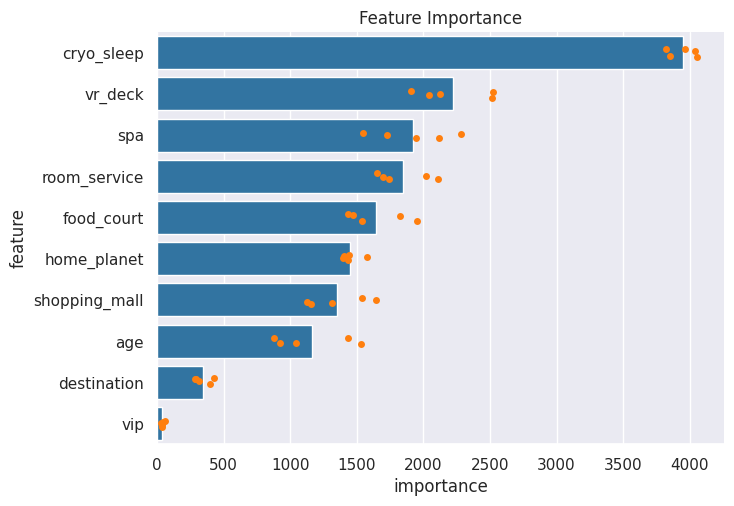

In [16]:
trainer_cv.plot_feature_importance()

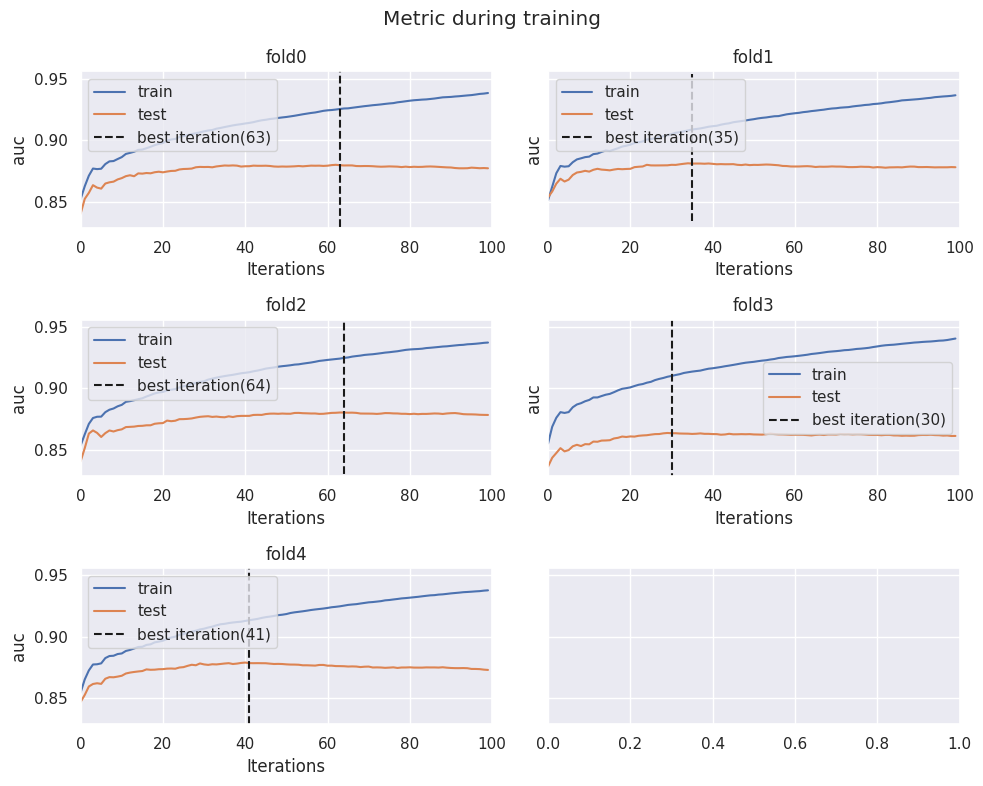

In [17]:
trainer_cv.plot_evals_result(metric="auc")

In [18]:
import joblib

joblib.dump(
    trainer_cv,
    "trainer.pkl",
    compress=3,
)

['trainer.pkl']

In [19]:
trainer = joblib.load("trainer.pkl")
trainer

LGBMTrainerCV(estimator=LGBMClassifier(colsample_bytree=0.6, force_row_wise=True, random_state=0,
               subsample=0.6, subsample_freq=1), preprocessor=FunctionTransformer(feature_names_out='one-to-one',
                    func=<function downcast_dtype at 0x7f5785568ca0>), scorers={'accuracy': make_scorer(accuracy_score), 'f1': make_scorer(f1_score, average=binary), 'roc_auc': make_scorer(roc_auc_score, needs_threshold=True)}, cv=KFold(n_splits=5, random_state=None, shuffle=True), voting='soft', weights=None, flatten_transform=True, callbacks=[<mylib.train.gbdt._callbacks.MlflowCallback object at 0x7f577172fbe0>])

/usr/local/lib/python3.9/site-packages/lightgbm/plotting.py:381: UserWarning: More than one metric available, picking one to plot.
  _log_warning("More than one metric available, picking one to plot.")


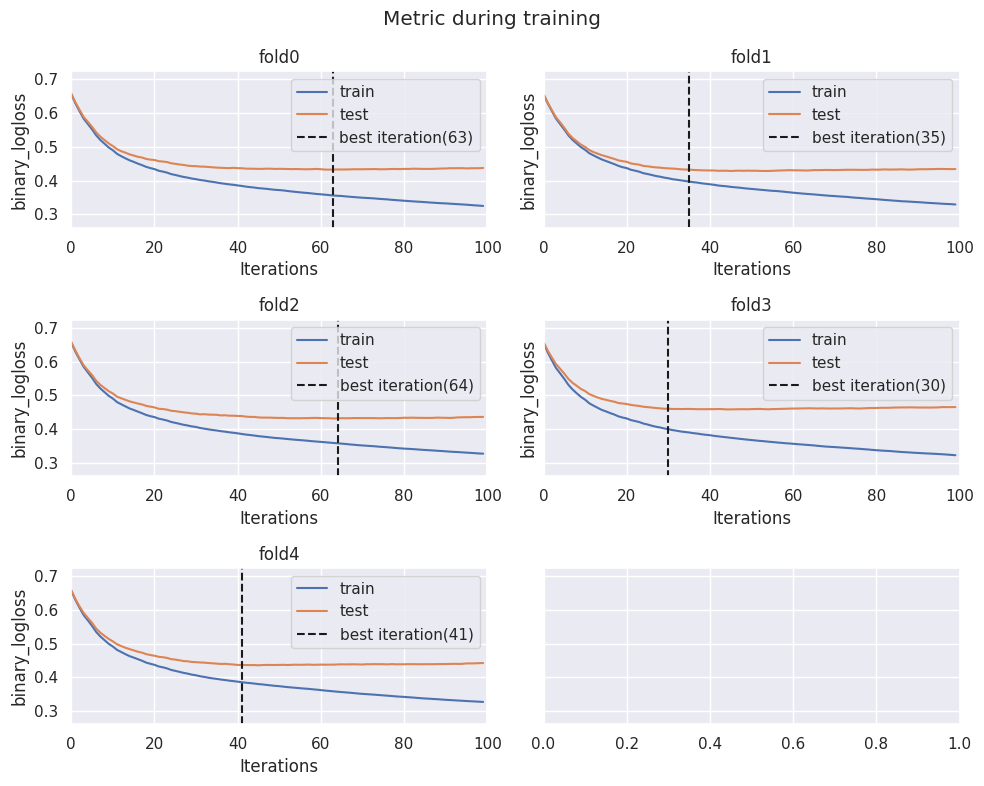

In [20]:
trainer.plot_evals_result()

In [38]:
trainer_cv.predict(X)

2024/01/22 11:30:10 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.9/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2024/01/22 11:30:10 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.9/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2024/01/22 11:30:10 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.9/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2024/01/22 11:30:10 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.9/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. 

array([1, 0, 0, ..., 1, 0, 1])